In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from torchsummary import summary
import dill

In [69]:
df = pd.read_csv('fnma loan data.csv')

In [70]:
df.columns

Index(['Unnamed: 0', 'index', 'Enterprise Flag', 'Record Number',
       'US Postal State Code', 'Metropolitan Statistical Area (MSA) Code',
       'County - 2010 Census', 'Census Tract - 2010 Census',
       '2010 Census Tract - Percent Minority',
       '2010 Census Tract - Median Income', 'Local Area Median Income',
       'Tract Income Ratio', 'Borrower’s (or Borrowers’) Annual Income',
       'Area Median Family Income (2016)', 'Borrower Income Ratio',
       'Acquisition Unpaid Principal Balance (UPB)', 'Purpose of Loan',
       'Federal Guarantee', 'Number of Borrowers', 'First-Time Home Buyer',
       'Borrower Race or National Origin 1-5 #1',
       'Borrower Race or National Origin 1-5 #2',
       'Borrower Race or National Origin 1-5 #3',
       'Borrower Race or National Origin 1-5 #4',
       'Borrower Race or National Origin 1-5 #5', 'Borrower Ethnicity',
       'Co-Borrower Race or National Origin 1-5 #1',
       'Co-Borrower Race or National Origin 1-5 #2',
       'Co-B

In [71]:
# Creaitng the features and target from the dataset
features_list = [
    'Record Number',
    "Borrower’s (or Borrowers’) Annual Income",
    "Area Median Family Income (2016)",
    "Tract Income Ratio",
    "2010 Census Tract - Median Income",
    "Purpose of Loan",
    "Number of Borrowers",
    "First-Time Home Buyer",
    "Federal Guarantee",
    "Property Type",
    "Rate Spread",
    "Occupancy Code",
    "US Postal State Code",
    "Metropolitan Statistical Area (MSA) Code",
    "Lien Status"
]

features = df[features_list].values
target = df['Acquisition Unpaid Principal Balance (UPB)'].values

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

In [72]:
l = []
for i in X_train:
    l.append(i[0])

t = []
for i in X_test:
    t.append(i[0])

217149.0

In [95]:
t[-31]

465733.0

In [74]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [75]:
with open('scaler.scl', 'wb') as fh:
    dill.dump(scaler, fh)
    fh.close()

In [76]:
X_train.shape

(70860, 15)

In [77]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

In [78]:
# creating the model
class BaselineModel(nn.Module):
  def __init__(self):
    super(BaselineModel, self).__init__()
    self.fc1 = nn.Linear(15, 512)
    self.fc2 = nn.Linear(512, 512)
    self.fc3 = nn.Linear(512, 64)
    self.fc4 = nn.Linear(64, 1)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.relu(self.fc3(x))
    x = self.fc4(x)
    return x

model = BaselineModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
# Training the Model

train_losses, test_losses, train_accuracies, test_accuracies, train_errors, test_errors = [], [], [], [], [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test)
        test_loss = criterion(test_predictions, y_test).item()

        train_predictions = model(X_train)
        train_rmse = root_mean_squared_error(y_train.numpy(), train_predictions.numpy())
        test_rmse = root_mean_squared_error(y_test.numpy(), test_predictions.numpy())

        train_nrmse = train_rmse/(y_train.max() - y_train.min())
        test_nrmse = test_rmse/(y_test.max() - y_test.min())

        train_accuracy = (1 - train_nrmse)*100
        test_accuracy = (1 - test_nrmse)*100


    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Training Loss: {train_loss:.4f}, Testing Loss: {test_loss:.4f}")
        print(f"  RMSE Error(Training): {train_rmse:.2f}, RMSE Error(Testing): {test_rmse:.2f}")

Epoch [10/100]
  Training Loss: 9445311572.3702, Testing Loss: 9426423808.0000
  RMSE Error(Training): 96159.02, RMSE Error(Testing): 97089.77
Epoch [20/100]
  Training Loss: 7840995075.3517, Testing Loss: 7420719104.0000
  RMSE Error(Training): 84941.35, RMSE Error(Testing): 86143.59
Epoch [30/100]
  Training Loss: 7341258881.0402, Testing Loss: 7066116096.0000
  RMSE Error(Training): 82845.62, RMSE Error(Testing): 84060.20
Epoch [40/100]
  Training Loss: 7085601908.6158, Testing Loss: 6911779840.0000
  RMSE Error(Training): 82023.25, RMSE Error(Testing): 83137.12
Epoch [50/100]
  Training Loss: 6935244450.9616, Testing Loss: 6820709376.0000
  RMSE Error(Training): 81456.98, RMSE Error(Testing): 82587.59
Epoch [60/100]
  Training Loss: 6812622422.7973, Testing Loss: 6627205120.0000
  RMSE Error(Training): 80203.16, RMSE Error(Testing): 81407.65
Epoch [70/100]
  Training Loss: 6759817835.4853, Testing Loss: 6570440704.0000
  RMSE Error(Training): 79694.27, RMSE Error(Testing): 81058.26

Text(0, 0.5, ' Train Accuracy')

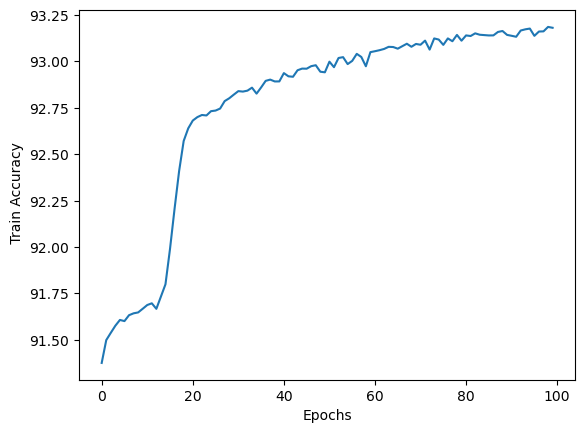

In [11]:
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel(' Train Accuracy')

Text(0, 0.5, 'Test Accuracy')

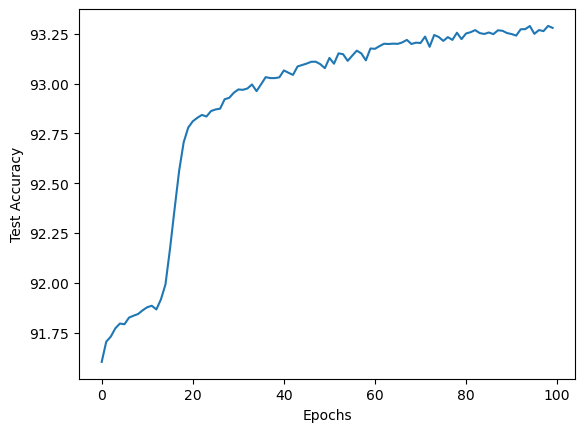

In [12]:
plt.plot(test_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')

Text(0, 0.5, 'Train Loss')

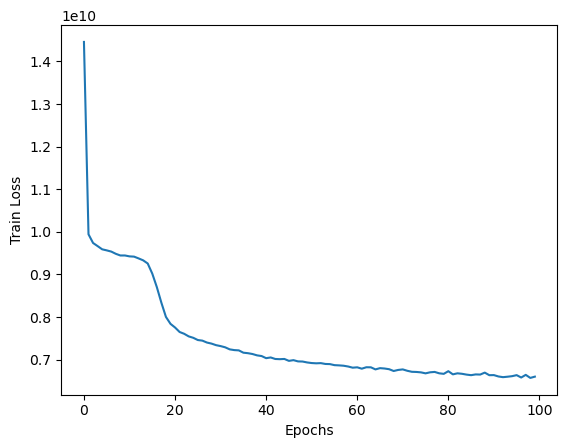

In [13]:
plt.plot(train_losses, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')

Text(0, 0.5, 'Test Loss')

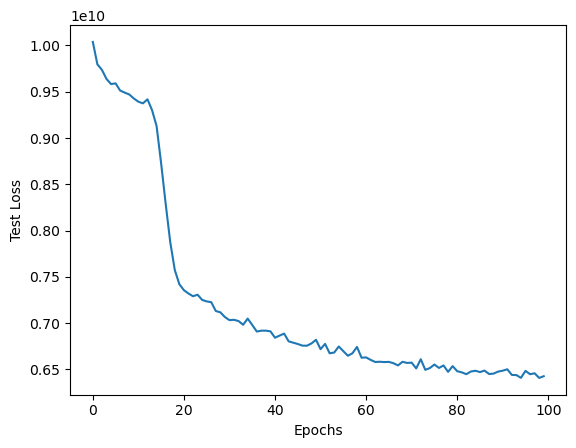

In [14]:
plt.plot(test_losses, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')

In [15]:
summary(model, (15,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]           8,192
              ReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 512]         262,656
              ReLU-5                  [-1, 512]               0
           Dropout-6                  [-1, 512]               0
            Linear-7                   [-1, 64]          32,832
              ReLU-8                   [-1, 64]               0
            Linear-9                    [-1, 1]              65
Total params: 303,745
Trainable params: 303,745
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.16
Estimated Total Size (MB): 1.18
-------------------------------------------

### Implementing the SISA Training Algorithm

In [79]:
# Using dataclasses to define Shard and Slice as a seperate datastructure to efficiently store information about them.
from dataclasses import dataclass


@dataclass
class Shard:
    shard_index: int
    x_shard: torch.tensor
    y_shard: torch.tensor

@dataclass
class Slice:
    shard_index: int
    slice_index: int
    x_slice: torch.tensor
    y_slice: torch.tensor

# Creates the shards of the data and returns a list of Shards
def create_shards(x, y, num_shards):
    shard_size = len(x) // num_shards
    shards = [
        Shard(
            shard_index=i,
            x_shard=x[i * shard_size:(i + 1) * shard_size],
            y_shard=y[i * shard_size:(i + 1) * shard_size]
        )
        for i in range(num_shards)
    ]
    return shards
# creates the slices of the given shard and returns a list of slices
def create_slices(shard, num_slices):
    x, y = shard.x_shard, shard.y_shard
    slice_size = len(x) // num_slices
    slices = [
        Slice(
            shard_index=shard.shard_index,  # Track which shard this slice belongs to
            slice_index=i,                 # Track which slice it is within the shard
            x_slice=x[i * slice_size:(i + 1) * slice_size],
            y_slice=y[i * slice_size:(i + 1) * slice_size]
        )
        for i in range(num_slices)
    ]
    return slices

In [80]:
# creating shards and slices of the training and the testing datasets
num_shards = 30
num_slices = 25
print(X_train.shape)
# for training data
train_shards = create_shards(X_train, y_train, num_shards)
train_slices = [
    create_slices(shard, num_slices)
    for shard in train_shards
]

# for testing data
test_shards = create_shards(X_test, y_test, num_shards)
test_slices = [
    create_slices(shard, num_slices)
    for shard in test_shards
]
print(X_train.shape)

torch.Size([70860, 15])
torch.Size([70860, 15])


In [18]:
# creating a data class which will store the model and the shard it belongs to

@dataclass
class shard_model:
    shard_index: int
    model: nn.Module
    model_params: list

shard_models = []
for shard_idx in range(num_shards):
      # define the model for the shard
      model = BaselineModel()
      criterion = nn.MSELoss()
      optimizer = optim.Adam(model.parameters(), lr=0.001)
      num_epochs = 100
      BATCH_SIZE = 32
      X_train = 0
      y_train = 0
      model_params = []
      for slice_idx in range(num_slices):
            '''Train the model for the shard on slice 1, then on the union of slice 1 and 2 and so on'''
            if slice_idx == 0:
                  X_train = train_slices[shard_idx][slice_idx].x_slice
                  y_train = train_slices[shard_idx][slice_idx].y_slice
            else:
                  X_train = torch.cat((X_train, train_slices[shard_idx][slice_idx].x_slice))
                  y_train = torch.cat((y_train, train_slices[shard_idx][slice_idx].y_slice))

            train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
              
            # training the model
            for epoch in range(num_epochs):
                  model.train()
                  for batch_X, batch_y in train_loader:
                        predictions = model(batch_X)
                        loss = criterion(predictions, batch_y)
                          
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

            model_params.append(model.state_dict())
            print('Shard:- {0}, Slice:- {1}'.format(shard_idx, slice_idx))
            
      Model = shard_model(shard_idx, model, model_params)
      shard_models.append(Model)


Shard:- 0, Slice:- 0
Shard:- 0, Slice:- 1
Shard:- 0, Slice:- 2
Shard:- 0, Slice:- 3
Shard:- 0, Slice:- 4
Shard:- 0, Slice:- 5
Shard:- 0, Slice:- 6
Shard:- 0, Slice:- 7
Shard:- 0, Slice:- 8
Shard:- 0, Slice:- 9
Shard:- 0, Slice:- 10
Shard:- 0, Slice:- 11
Shard:- 0, Slice:- 12
Shard:- 0, Slice:- 13
Shard:- 0, Slice:- 14
Shard:- 0, Slice:- 15
Shard:- 0, Slice:- 16
Shard:- 0, Slice:- 17
Shard:- 0, Slice:- 18
Shard:- 0, Slice:- 19
Shard:- 0, Slice:- 20
Shard:- 0, Slice:- 21
Shard:- 0, Slice:- 22
Shard:- 0, Slice:- 23
Shard:- 0, Slice:- 24
Shard:- 1, Slice:- 0
Shard:- 1, Slice:- 1
Shard:- 1, Slice:- 2
Shard:- 1, Slice:- 3
Shard:- 1, Slice:- 4
Shard:- 1, Slice:- 5
Shard:- 1, Slice:- 6
Shard:- 1, Slice:- 7
Shard:- 1, Slice:- 8
Shard:- 1, Slice:- 9
Shard:- 1, Slice:- 10
Shard:- 1, Slice:- 11
Shard:- 1, Slice:- 12
Shard:- 1, Slice:- 13
Shard:- 1, Slice:- 14
Shard:- 1, Slice:- 15
Shard:- 1, Slice:- 16
Shard:- 1, Slice:- 17
Shard:- 1, Slice:- 18
Shard:- 1, Slice:- 19
Shard:- 1, Slice:- 20
Shard:- 

In [20]:
with open('shard_models.mdl', 'wb') as fh:
      dill.dump(shard_models, fh)
      fh.close()

In [81]:
with open('X_test.dat', 'wb') as fh:
    dill.dump(X_test, fh)
    fh.close()
with open('X_train.dat', 'wb') as fh:
    dill.dump(X_train, fh)
    fh.close()
with open('y_test.dat', 'wb') as fh:
    dill.dump(y_test, fh)
    fh.close()
with open('y_train.dat', 'wb') as fh:
    dill.dump(y_train, fh)
    fh.close()

In [82]:
with open('test_shards.shrds', 'wb') as fh:
    dill.dump(test_shards, fh)
    fh.close()
with open('train_shards.shrds', 'wb') as fh:
    dill.dump(train_shards, fh)
    fh.close()

with open('train_slices.sls', 'wb') as fh:
    dill.dump(train_slices, fh)
    fh.close()
with open('test_slices.sls', 'wb') as fh:
    dill.dump(test_slices, fh)
    fh.close()


In [25]:
# getting the output by taking the mean of the output of the shard models
sharded_test_predictions = []
sharded_train_predictions = []
for shard_model in shard_models:
    shard_model.model.eval()
    test_pred = (shard_model.model(X_test)).detach().numpy()
    train_pred = (shard_model.model(X_train)).detach().numpy()
    sharded_test_predictions.append(test_pred)
    sharded_train_predictions.append(train_pred)

sharded_test_predictions = np.array(sharded_test_predictions)
sharded_train_predictions = np.array(sharded_train_predictions)
mean_test_predictions = np.mean(sharded_test_predictions, axis=0)
mean_train_predictions = np.mean(sharded_train_predictions, axis=0)

test_rmse = root_mean_squared_error(mean_test_predictions, y_test)
train_rmse = root_mean_squared_error(mean_train_predictions, y_train)

print(f"Train RMSE:- {train_rmse}")
print(f"Test RMSE:- {test_rmse}")

Train RMSE:- 82346.1328125
Test RMSE:- 83218.625


In [23]:
# To find the point to be deleted and to find the shard and the slice in which it belongs

def find_shard_slice(to_delete: torch.tensor, num_shards: int, num_slices: int, slices: list) -> tuple:
    '''Finds the shard index, slice index and index of the specific data point in the slice and returns them as a tuple'''
    for shard_idx in range(num_shards):
        for slice_idx in range(num_slices):
            for idx in range(len(slices[shard_idx][slice_idx].x_slice)):
                if torch.allclose(to_delete, train_slices[shard_idx][slice_idx].x_slice[idx]):
                   return (shard_idx, slice_idx, idx)

def del_data(shard_idx: int, slice_idx: int, idx: int, slices: list):
    '''Takes the shard index, slice index and the index of the data point and deletes it'''
    new_x_slice = torch.cat((slices[shard_idx][slice_idx].x_slice[:idx], slices[shard_idx][slice_idx].x_slice[idx+1:]))
    new_y_slice = torch.cat((slices[shard_idx][slice_idx].y_slice[:idx], slices[shard_idx][slice_idx].y_slice[idx+1:]))
    slices[shard_idx][slice_idx].x_slice = new_x_slice
    slices[shard_idx][slice_idx].y_slice = new_y_slice
    print(f"Data of shard {shard_idx} in slice {slice_idx} at index of {idx} deleted successfully")


pt_to_del = int(input("Enter record number to delete:- "))
df2 = df[features_list]
pt_to_del = df2[df['Record Number'] == pt_to_del].values
pt_to_del = torch.tensor(scaler.transform(pt_to_del)).to(torch.float32)
indices = find_shard_slice(pt_to_del, num_shards, num_slices, train_slices)
shard_idx_todel = indices[0]
slice_idx_todel = indices[1]
idx_todel = indices[2]
indices
del_data(shard_idx_todel, slice_idx_todel, idx_todel, train_slices)

Data of shard 0 in slice 10 at index of 60 deleted successfully


In [32]:
import torch.utils.data.dataloader


model = shard_models[shard_idx_todel].model 

if slice_idx_todel == 0:
    # if the first slice of shard has been changed then retrain the model from the beginning
    shard_models[shard_idx_todel].model_params = []
    unl_model_params = []
    for slice_idx in range(num_slices):
        if slice_idx == 0:
            x = train_slices[shard_idx_todel][0].x_slice
            y = train_slices[shard_idx_todel][0].y_slice
        else:
            x = torch.cat((x, train_slices[shard_idx_todel][slice_idx].x_slice))
            y = torch.cat((y, train_slices[shard_idx_todel][slice_idx].y_slice))
        train_dataset = torch.utils.data.TensorDataset(x, y)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
              
        # training the model
        for epoch in range(num_epochs):
                model.train()
                for batch_X, batch_y in train_loader:
                    predictions = model(batch_X)
                    loss = criterion(predictions, batch_y)
                          
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
        unl_model_params.append(model.state_dict())
        print('Shard:- {0}, Slice:- {1}'.format(shard_idx_todel, slice_idx))
    shard_models[shard_idx_todel].model_params = unl_model_params

else:
    shard_models[shard_idx_todel].model_params = shard_models[shard_idx_todel].model_params[: slice_idx_todel - 1]
    unl_model_params = []

    for slice_idx in range(slice_idx_todel, num_slices):
        if slice_idx == slice_idx_todel:
            x = train_slices[shard_idx_todel][slice_idx].x_slice[:slice_idx + 1]
            y = train_slices[shard_idx_todel][slice_idx].y_slice[:slice_idx + 1]
        else:
            x = torch.cat([x, train_slices[shard_idx_todel][slice_idx].x_slice])
            y = torch.cat([y, train_slices[shard_idx_todel][slice_idx].y_slice])
        train_dataset = torch.utils.data.TensorDataset(x, y)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        for epoch in range(num_epochs):
            model.train()
            for batch_X, batch_y in train_loader:
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        unl_model_params.append(model.state_dict())
        print('Shard:- {0}, Slice:- {1}'.format(shard_idx_todel, slice_idx))
    shard_models[shard_idx_todel].model_params[slice_idx_todel:] = unl_model_params

print('Unlearning Done Successfully')


Shard:- 0, Slice:- 10
Shard:- 0, Slice:- 11
Shard:- 0, Slice:- 12
Shard:- 0, Slice:- 13
Shard:- 0, Slice:- 14
Shard:- 0, Slice:- 15
Shard:- 0, Slice:- 16
Shard:- 0, Slice:- 17
Shard:- 0, Slice:- 18
Shard:- 0, Slice:- 19
Shard:- 0, Slice:- 20
Shard:- 0, Slice:- 21
Shard:- 0, Slice:- 22
Shard:- 0, Slice:- 23
Shard:- 0, Slice:- 24
Unlearning Done Successfully


In [33]:
# Checking the RMSE of the new model
sharded_test_predictions = []
sharded_train_predictions = []
for shard_model in shard_models:
    test_pred = (shard_model.model(X_test)).detach().numpy()
    train_pred = (shard_model.model(X_train)).detach().numpy()
    sharded_test_predictions.append(test_pred)
    sharded_train_predictions.append(train_pred)

sharded_test_predictions = np.array(sharded_test_predictions)
sharded_train_predictions = np.array(sharded_train_predictions)
mean_test_predictions = np.mean(sharded_test_predictions, axis=0)
mean_train_predictions = np.mean(sharded_train_predictions, axis=0)

test_rmse = root_mean_squared_error(mean_test_predictions, y_test)
train_rmse = root_mean_squared_error(mean_train_predictions, y_train)

print(f"Train RMSE:- {train_rmse}")
print(f"Test RMSE:- {test_rmse}")

Train RMSE:- 83064.0859375
Test RMSE:- 83199.515625
